In [368]:
from proxmin import nmf
from proxmin.utils import Traceback
from scipy.optimize import linear_sum_assignment
from scipy.stats import binned_statistic
import numpy as np
import matplotlib.pyplot as plt
import time
from proxmin import operators as po
from functools import partial

In [369]:
data = np.load("hsc_stacked.npy")

In [370]:
redshifts = data['z_cl']

# Bin the cluster data by redshift
clusters1 = data[(redshifts > 0.1) & (redshifts < 0.2)]
clusters2 = data[(redshifts > 0.2) & (redshifts < 0.35)]
clusters3 = data[(redshifts > 0.35) & (redshifts < 0.5)]
clusters4 = data[(redshifts > 0.5) & (redshifts < 0.75)]
clusters5 = data[(redshifts > 0.75) & (redshifts < 1.2)]

In [371]:
num_radial_bins = 15

In [372]:
# Compute the average colors (and their variances) for a given redshift bin

def avg_colors(clusters):
    
    clusters = clusters[np.where(clusters['R'] > 0.01)]
    radii = np.array(clusters['R'])
    #radii = radii[np.where(radii > 0.01)]
    radial_bins = np.logspace(np.log10(np.amin(radii)), np.log10(np.amax(radii)), num_radial_bins + 1)
    #print(radial_bins)
    widths = np.diff(radial_bins)

    # Arrays containing magnitude data in four different filters
    g = np.array(clusters['gmag_forced_cmodel'])
    r = np.array(clusters['rmag_forced_cmodel'])
    i = np.array(clusters['imag_forced_cmodel'])
    z = np.array(clusters['zmag_forced_cmodel'])

    # For each color g-r, r-i, and i-z: first, throw out data points that have magnitudes of "nan" or "inf" (pruning the
    # arrays of radii and magnitudes accordingly), then use scipy.binned_statistic to sort the data into radial bins and
    # compute the mean and variance (noise^2) of the color values in those bins

    radii_gr_pruned = radii[np.isfinite(g) & np.isfinite(r)]
    gr = g[np.isfinite(g) & np.isfinite(r)] - r[np.isfinite(g) & np.isfinite(r)]
    count_gr = binned_statistic(radii_gr_pruned, gr, 'count', radial_bins)[0]
    mean_gr = binned_statistic(radii_gr_pruned, gr, 'mean', radial_bins)[0]
    var_gr = binned_statistic(radii_gr_pruned, gr, np.var, radial_bins)[0]
    var_gr /= count_gr

    radii_ri_pruned = radii[np.isfinite(r) & np.isfinite(i)]
    ri = r[np.isfinite(r) & np.isfinite(i)] - i[np.isfinite(r) & np.isfinite(i)]
    count_ri = binned_statistic(radii_ri_pruned, ri, 'count', radial_bins)[0]
    mean_ri = binned_statistic(radii_ri_pruned, ri, 'mean', radial_bins)[0]
    var_ri = binned_statistic(radii_ri_pruned, ri, np.var, radial_bins)[0]
    var_ri /= count_ri

    radii_iz_pruned = radii[np.isfinite(i) & np.isfinite(z)]
    iz = i[np.isfinite(i) & np.isfinite(z)] - z[np.isfinite(i) & np.isfinite(z)]
    count_iz = binned_statistic(radii_iz_pruned, iz, 'count', radial_bins)[0]
    mean_iz = binned_statistic(radii_iz_pruned, iz, 'mean', radial_bins)[0]
    var_iz = binned_statistic(radii_iz_pruned, iz, np.var, radial_bins)[0]
    var_iz /= count_iz

    # Compute the mean and variance of the i magnitudes over the same radial bins as above
    radii_i_pruned = radii[np.isfinite(i)]
    count_i = binned_statistic(radii_i_pruned, i, 'count', radial_bins)[0]
    mean_i = binned_statistic(radii_i_pruned, i, 'mean', radial_bins)[0]
    var_i = binned_statistic(radii_i_pruned, i, np.var, radial_bins)[0]
    var_i /= count_i
    
    return (radial_bins, widths, (mean_gr, var_gr), (mean_ri, var_ri), (mean_iz, var_iz), (mean_i, var_i))

In [373]:
# Plot bar graphs for the average color data in a given redshift bin

def plot_profiles(clusters, z_bin_num):
    
    clusters_data = avg_colors(clusters)

    radial_bins = clusters_data[0]
    widths = clusters_data[1]
    
    # gr, ri, iz, and i are 2-tuples of the form (mean_color, var_color)
    gr = clusters_data[2]
    ri = clusters_data[3]
    iz = clusters_data[4]
    i = clusters_data[5]
    
    z_bins = ("1 (0.1 < z < 0.2)", "2 (0.2 < z < 0.35)", "3 (0.35 < z < 0.5)", "4 (0.5 < z < 0.75)", 
             "5 (0.75 < z < 1.2)")

    plt.bar(radial_bins[:-1], gr[0], width=widths, fill=False, align="edge", yerr=np.sqrt(gr[1]))
    plt.xscale('log')
    plt.title("Average g-r Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average g-r [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], ri[0], width=widths, fill=False, align="edge", yerr=np.sqrt(ri[1]))
    plt.xscale('log')
    plt.title("Average r-i Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average r-i [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], iz[0], width=widths, fill=False, align="edge", yerr=np.sqrt(iz[1]))
    plt.xscale('log')
    plt.title("Average i-z Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average i-z [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], i[0], width=widths, fill=False, align="edge", yerr=np.sqrt(i[1]))
    plt.xscale('log')
    plt.title("Average i-filter Magnitude vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average i [magnitudes]")
    plt.show()
    
    return clusters_data

In [374]:
# Use NMF to unmix the color profiles generated by plot_profiles and avg_colors
# The arguments of "unmix" are 2-tuples of the form (mean_color, var_color). For example, gr is really (mean_gr, var_gr)

def prox_field(S, step, bins=-4):
    S[0, bins:] = 1
    S[1:, bins:] = 0
    return S

def unmix(gr, ri, iz, i):
    n = num_radial_bins     # component resolution
    k = 2                   # number of components
    b = 4                   # number of observations (b=4 for g-r, r-i, i-z, and i)

    # Data matrix to be unmixed
    Y = np.array([gr[0], ri[0], iz[0], i[0]])
    
    # if noise is variable, specify variance matrix of the same shape as Y
    W = 1. / np.array([gr[1], ri[1], iz[1], i[1]])

    # initialize and run NMF
    A = np.random.uniform(size = (b, k))
    S = np.random.uniform(size = (k, n))
    pA = po.prox_id
    
    psum = partial(po.prox_unity_plus, axis=0)
    pfield = partial(prox_field, bins=-4)
    pS = po.AlternatingProjections([pfield, psum])
    
    nmf(Y, A, S, W=W, prox_A=pA, prox_S=pS, e_rel=1e-6, e_abs=0)
    
    return A, S

In [375]:
def plot_factorized_profiles(clusters_data, z_bin_num):
    

    radial_bins = clusters_data[0]
    bin_midpoints = (radial_bins[1:] * radial_bins[:-1]) ** 0.5
    widths = clusters_data[1]
    
    # gr, ri, iz, and i are 2-tuples of the form (mean_color, var_color)
    A, S = unmix(gr = clusters_data[2], ri = clusters_data[3], iz = clusters_data[4], i = clusters_data[5])
    print("A:\n", A, "\n")
    print("S:\n", S, "\n")
    
    z_bins = ("1 (0.1 < z < 0.2)", "2 (0.2 < z < 0.35)", "3 (0.35 < z < 0.5)", "4 (0.5 < z < 0.75)", 
             "5 (0.75 < z < 1.2)")
    
    # Plot S_k (the relative abundance of the kth component) vs. radius for each k
    
    for k in range(S.shape[0]):
        plt.plot(bin_midpoints, S[k], label = "Component %s" % (k+1))
    plt.xscale('log')
    plt.title("Relative Component Abundance vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel("Relative abundance")
    plt.legend()
    plt.show()
    
    
    Y_remixed = np.dot(A, S)
    
    # Plot the reconstructed color profiles following NMF 
    # (that is, plot Y_remixed = A x S, where A and S are the results of factorizing the initial data matrix Y)
    
    '''
    plt.bar(radial_bins[:-1], Y_remixed[0], width=widths, fill=False, align="edge")#, yerr=np.sqrt(gr[1]))
    plt.xscale('log')
    plt.title("Re-Mixed Average g-r Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average g-r [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], Y_remixed[1], width=widths, fill=False, align="edge")#, yerr=np.sqrt(ri[1]))
    plt.xscale('log')
    plt.title("Re-Mixed Average r-i Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average r-i [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], Y_remixed[2], width=widths, fill=False, align="edge")#, yerr=np.sqrt(iz[1]))
    plt.xscale('log')
    plt.title("Re-Mixed Average i-z Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average i-z [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], Y_remixed[3], width=widths, fill=False, align="edge")#, yerr=np.sqrt(i[1]))
    plt.xscale('log')
    plt.title("Re-Mixed Average i-filter Magnitude vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average i [magnitudes]")
    plt.show()
    
    
    # Plot the components (that is, the rows of S) for a given redshift bin
    
    plt.bar(radial_bins[:-1], S[0], width=widths, fill=False, align="edge")#, yerr=np.sqrt(i[1]))
    plt.xscale('log')
    plt.title("Component 1 for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average color [magnitudes]")
    plt.show()
    
    plt.bar(radial_bins[:-1], S[1], width=widths, fill=False, align="edge")#, yerr=np.sqrt(i[1]))
    plt.xscale('log')
    plt.title("Component 2 for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average color [magnitudes]") 
    plt.show()
    
    plt.bar(radial_bins[:-1], S[2], width=widths, fill=False, align="edge")#, yerr=np.sqrt(i[1]))
    plt.xscale('log')
    plt.title("Component 3 for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average color [magnitudes]")
    plt.show()
    '''
    

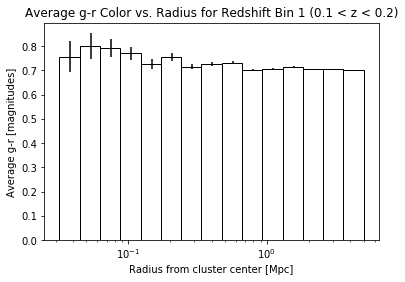

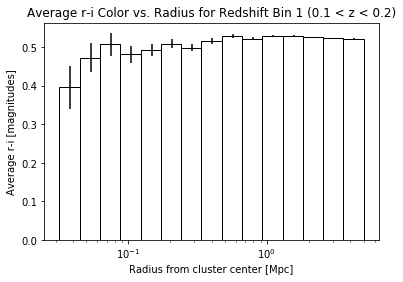

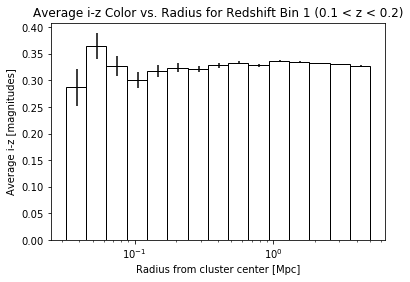

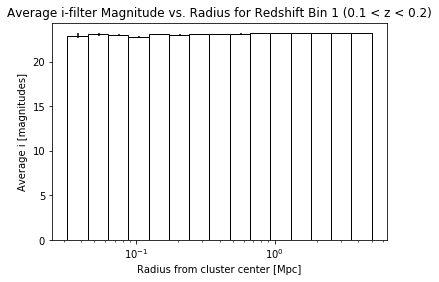

In [376]:
#Plot bar graphs for the clusters1 data

clusters1_data = plot_profiles(clusters1, 1)

A:
 [[  0.72048726   0.76344569]
 [  0.50131694   0.50834621]
 [  0.32958394   0.31874661]
 [ 23.13572659  22.94910462]] 

S:
 [[ 0.86612693  0.91374421  0.19884517  0.39567979  0.37705532  0.41728873
   1.          0.57722836  0.50770742  0.50329799  0.49984855  1.          1.
   1.          1.        ]
 [ 0.13387307  0.08625579  0.80115483  0.60432021  0.62294468  0.58271127
   0.          0.42277164  0.49229258  0.49670201  0.50015145  0.          0.
   0.          0.        ]] 



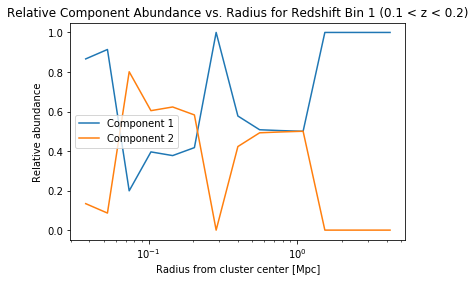

In [377]:
#Plot bar graphs for the post-NMF clusters1 profiles

plot_factorized_profiles(clusters1_data, 1)

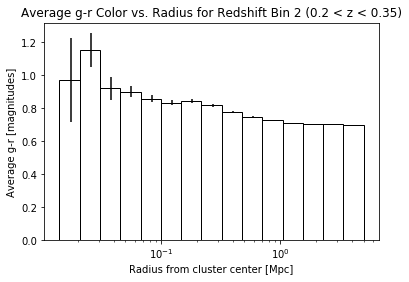

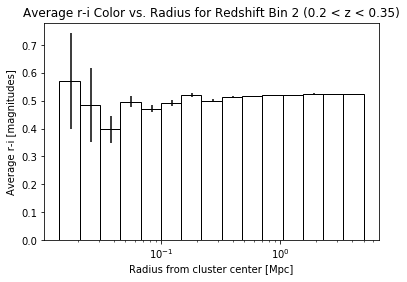

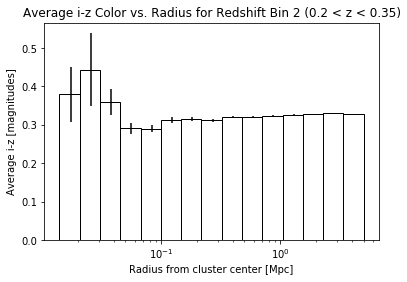

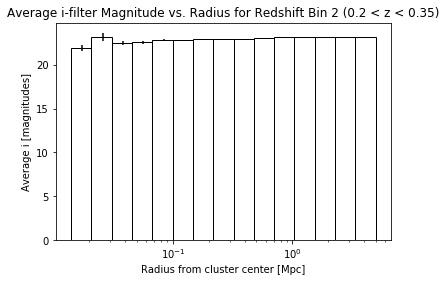

In [378]:
#Plot bar graphs for the clusters2 data

clusters2_data = plot_profiles(clusters2, 2)

A:
 [[  0.79072967   0.89265009]
 [  0.52361149   0.46804135]
 [  0.34551936   0.30628255]
 [ 23.14417871  22.41884294]] 

S:
 [[ 0.57831673  0.99265965  0.17492546  0.23797841  0.50564016  0.83515736
   0.52417676  0.51130621  0.50999176  0.50751119  0.50875326  1.          1.
   1.          1.        ]
 [ 0.42168327  0.00734035  0.82507454  0.76202159  0.49435984  0.16484264
   0.47582324  0.48869379  0.49000824  0.49248881  0.49124674  0.          0.
   0.          0.        ]] 



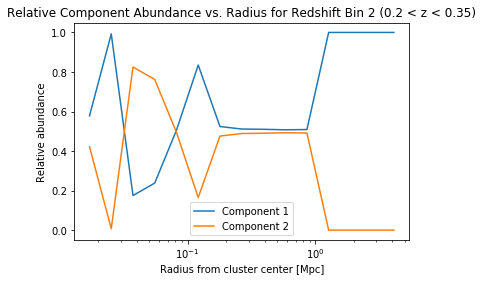

In [379]:
#Plot bar graphs for the post-NMF clusters2 profiles

plot_factorized_profiles(clusters2_data, 2)

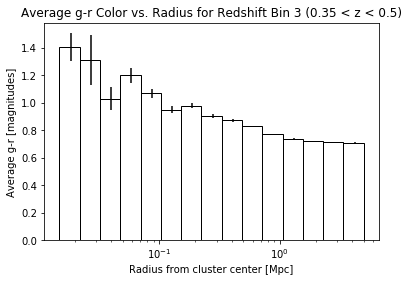

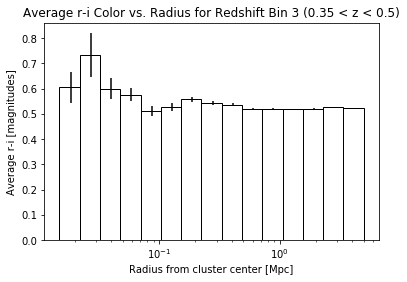

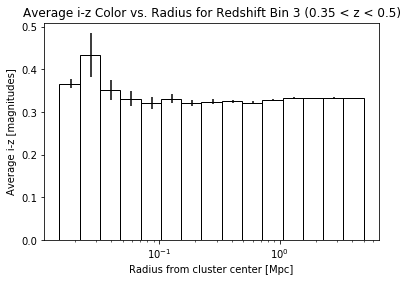

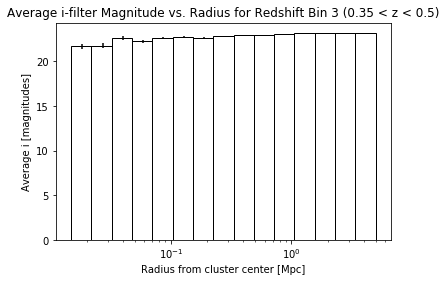

In [380]:
#Plot bar graphs for the clusters3 data

clusters3_data = plot_profiles(clusters3, 3)

A:
 [[  0.84928065   1.12358716]
 [  0.54552652   0.57037808]
 [  0.34377396   0.33088973]
 [ 22.88457731  22.46471653]] 

S:
 [[ 1.          0.57830802  0.49632128  0.21331175  0.33888781  0.53688001
   0.49011536  0.50837353  0.50329593  0.50477526  0.50541805  1.          1.
   1.          1.        ]
 [ 0.          0.42169198  0.50367872  0.78668825  0.66111219  0.46311999
   0.50988464  0.49162647  0.49670407  0.49522474  0.49458195  0.          0.
   0.          0.        ]] 



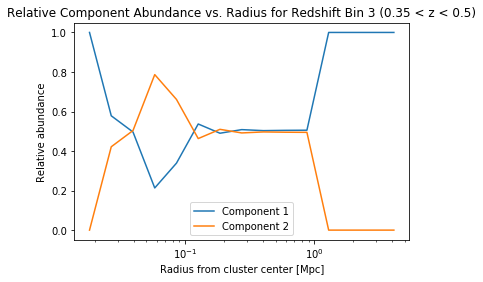

In [381]:
#Plot bar graphs for the post-NMF clusters3 profiles

plot_factorized_profiles(clusters3_data, 3)

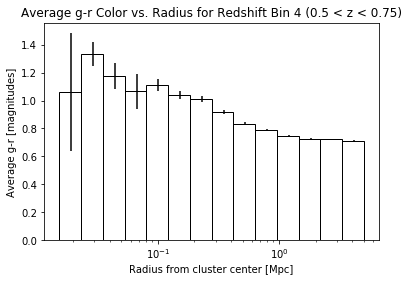

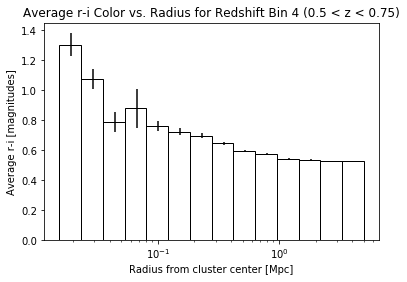

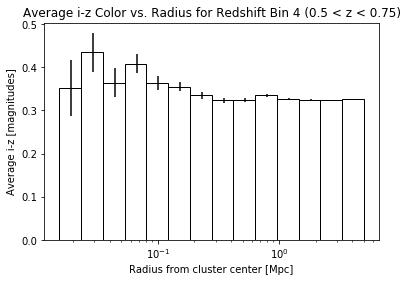

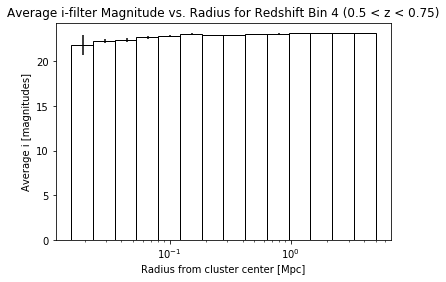

In [382]:
#Plot bar graphs for the clusters4 data

clusters4_data = plot_profiles(clusters4, 4)

In [383]:
#Plot bar graphs for the post-NMF clusters4 profiles

plot_factorized_profiles(clusters4_data, 4)

ArpackNoConvergence: ARPACK error -1: No convergence (81 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]

In [ ]:
#Plot bar graphs for the clusters5 data

clusters5_data = plot_profiles(clusters5, 5)

In [ ]:
#Plot bar graphs for the post-NMF clusters5 profiles

plot_factorized_profiles(clusters5_data, 5)